In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
import re

In [2]:
date = ['2012/08/09','2012/08/12', '2012/08/15', '2012/08/17', '2012/08/13', '2012/08/19', '2012/08/17', '2012/09/22', '2012/09/20','2012/09/12','2012/09/18','2012/09/16','2012/11/2','2012/10/5','2012/10/10','2012/10/15', '2012/10/11','2012/08/20', '2012/08/13','2012/10/12', '2012/08/2', '2012/08/11', '2012/08/3','2012/08/17', '2012/12/1','2012/12/29',] 

In [3]:
reviewer = ['1','2','3','4','9','10','5','4','5','6','7','8','3','3','4','7','8','2','5','9','4','5','6','10','5','4']

In [4]:
product = ['1','1','1','1','2','2','2','3','3','3','3','3','7','4','4','4','4','5','5','5','6','6','6','6','8','9']

In [5]:
rating = ['1','1','2','1','5','5','5','5','5','5','4','5','5','5','5','5','5','3','4','5','5','5','5','5','5','1']

In [6]:
df = pd.DataFrame({'Date': date, 'Reviewer': reviewer, 'Product': product, 'Rating': rating})

In [7]:
df

,Date,Reviewer,Product,Rating
0,2012/08/09,1,1,1
1,2012/08/12,2,1,1
2,2012/08/15,3,1,2
3,2012/08/17,4,1,1
4,2012/08/13,9,2,5
5,2012/08/19,10,2,5
6,2012/08/17,5,2,5
7,2012/09/22,4,3,5
8,2012/09/20,5,3,5
9,2012/09/12,6,3,5


In [8]:
df['Date'] =  pd.to_datetime(df['Date'])

In [9]:
groups = df.groupby('Product')

In [10]:
alpha = 6

In [11]:
G = nx.Graph()
for index, g in groups: 
    def filter_on_date(g):
        result = []
        def get_time_diff(combination):
            diff = combination.iloc[0].Date - combination.iloc[-1].Date
            return diff.days
        
        edges = list(combinations(g.Reviewer, 2))

        for e in edges: 
            combination = g[g.Reviewer.isin(e)]
            diff = get_time_diff(combination)
            if abs(diff) > alpha:
                continue
            else:
                result.append(e)
        return result
    
    def filter_on_rating(g):
        result = []
        rating_g = g.groupby('Rating')
        
        for i, r_g in rating_g:
            result.append(r_g)
        return result
    
    rating_g = filter_on_rating(g)
    for g in rating_g: 
        date_g = filter_on_date(g)
        if len(date_g) > 0:
            for e in date_g:
                u = e[0]
                v = e[1]
                G.add_edge(u, v)

In [12]:
nx.draw(G, with_labels = True)

In [13]:
def filter_cliques(cliques, k):
    result = []
    for clique in cliques:
        if len(clique) >= k:
            result.append(clique)
    return result

In [14]:
cliques = list(nx.find_cliques(G))
cliques = filter_cliques(cliques, k=3)
cliques

[['10', '5', '9'],
 ['4', '8', '6'],
 ['4', '8', '5'],
 ['4', '8', '3'],
 ['4', '8', '7']]

In [15]:
beta = 2/3

In [16]:
def merge_cliques(cliques):
    
    def how_many_el_are_equal(clique, clique_search):
        result = 0
        
        for element in clique:
            if element in clique_search:
                result+=1        
        return result
        
    def get_arteficial_group(result_df):
        result = []
        arteficial_groups = result_df.groupby('common_elements').arteficial_grp.sum().values
        
        for group in arteficial_groups:
            numbers = re.findall('[0-9]+', group)
            result.append(list(set(numbers)))
        return result
    
    result = []
    k = 3
    proccesed_cliques = dict()
    for clique in cliques:
        proccesed_cliques.update({str(clique):1})
        for clique_search in cliques:
            
            # Grenzfälle
            if clique == clique_search:
                continue
            if str(clique_search) in proccesed_cliques:
                continue
            
            num_equal = how_many_el_are_equal(clique, clique_search)
            treshold_clique = ((num_equal/len(clique)))
            treshold_clique_search = ((num_equal/len(clique_search)))
            #print(treshold_clique, treshold_clique_search)  
            if treshold_clique == 1 or treshold_clique_search == 1:
                continue
            if treshold_clique>=beta or treshold_clique_search>=beta:
                
                
                common_elements = [x for x,y in zip(clique, clique_search) if x==y]
                arteficial_grp = set(clique + clique_search)
                
               
                #print(clique, clique_search, num_equal,  True, arteficial_grp, common_elements)
                result.append({'arteficial_grp' : str(arteficial_grp), 'common_elements' : str(common_elements)})
    if len(result) > 0:
        result_df = pd.DataFrame(result) 
        result = get_arteficial_group(result_df)
    return result
    

In [17]:
merge_cliques(cliques)

[['8', '3', '4', '5', '6', '7']]

In [18]:
cliques.extend(merge_cliques(cliques))

In [19]:
cliques

[['10', '5', '9'],
 ['4', '8', '6'],
 ['4', '8', '5'],
 ['4', '8', '3'],
 ['4', '8', '7'],
 ['8', '3', '4', '5', '6', '7']]

In [26]:
my_colors = ['red', 'blue', 'yellow', 'brown', 'green', 'blue']

In [27]:
G_cliques = nx.Graph()
for i, clique in enumerate(cliques):
    combination = combinations(clique, 2)
    for e in combination:
        u = e[0]
        v = e[1]
        G_cliques.add_edge(u, v, color=my_colors[i])

In [28]:
edges = G_cliques.edges()
colors = [G_cliques[u][v]['color'] for u,v in edges]

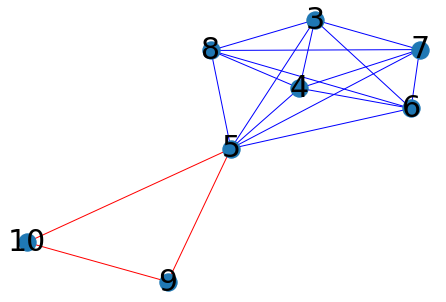

In [29]:
nx.draw(G_cliques, with_labels=True, font_size =30, edge_color=colors)